In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
base_fp = '/trace/group/rounce/cvwilson/Output/'

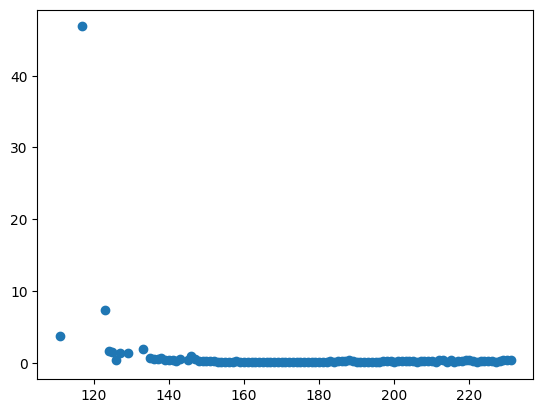

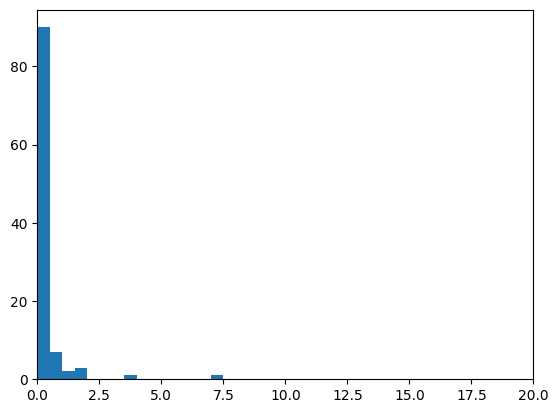

In [14]:
site = 'B'
ds = xr.open_dataset(base_fp + f'/08_01_{site}_0/grid_08_01_set73_run0_0.nc')
ds = ds.sel(time=pd.date_range('2024-04-01','2024-08-18',freq='h'))

def compute_daily_pdd_factor(ds):
    """
    Compute daily Positive Degree Day (PDD) factor from hourly temperature and melt data.

    Parameters:
        df (pd.DataFrame): DataFrame with hourly data.
    Returns:
        pd.DataFrame: Daily PDD factor with columns ['date', 'daily_melt', 'positive_temp_sum', 'pdd_factor']
    """

    # Clip temperature to positive values
    positive_temp = ds['airtemp'].clip(min=0)

    # Resample to daily
    daily_melt = ds['melt'].resample({'time': '1D'}).sum() * 1000
    daily_positive_temp = positive_temp.resample({'time': '1D'}).sum()

    # Compute PDD factor
    pdd_factor = daily_melt / daily_positive_temp
    pdd_factor = pdd_factor.where(np.isfinite(pdd_factor))  # mask inf/nan

    # Return as new dataset
    return xr.Dataset({
        'daily_melt': daily_melt,
        'positive_temp_sum': daily_positive_temp,
        'pdd_factor': pdd_factor
    })

pdds = compute_daily_pdd_factor(ds)
plt.scatter(pd.to_datetime(pdds['time'].values).day_of_year, pdds['pdd_factor'])
plt.show()

fig, ax = plt.subplots()
ax.hist(pdds['pdd_factor'], bins=np.arange(0, 20, 0.5))
ax.set_xlim(0, 20)
plt.show()